# imports

In [1]:
import os,sys
from pathlib import Path
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

In [6]:
# paths
root = Path.home()
config = root.joinpath("Code","atree","config")
sys.path += [str(root),str(config)]
# opPath = root.joinpath("Code","atree","outputs","groundwater","levels","preprocessed")
# print("data saved in :",opPath)

filePath = root.joinpath("Data","groundwater","aquifers","india_principal_aquifers.shp")
opPath = root.joinpath("Data","groundwater","aquifers","india_principal_aquifers_sy.shp")
aqCodesPath = root.joinpath("Data","groundwater","aquifers","india_principal_aquifers.csv")

# read in data

In [3]:
gdf = gpd.read_file(filePath,driver='shapefile')
print(gdf.columns)

Index(['fid', 'objectid', 'newcode14', 'aquifer', 'newcode43', 'aquifer0',
       'system', 'aquifers', 'zone_m', 'mbgl', 'avg_mbgl', 'm2_perday',
       'm3_per_day', 'yeild__', 'per_cm', 'state', 'pa_order', 'test',
       'area_re', 'st_area(sh', 'st_length(', 'RI_Factor', 'RI_Fac_Min',
       'RI_Fac_Max', 'geometry'],
      dtype='object')


In [ ]:
# after studying attribute table in QGIS,

# aquifer info is stored in hierarchical manner,
# 'newcode14' and 'aquifer' being the short code and type of aquifer, e.g. AL and Alluvium
# list all unique types
# 'newcode43' and 'aquifer0' are the short code and name of aquifer sub-type, e.g. AL05 and Coastal Alluvium (Sand, Silt, Clay)
# list all unique sub-types

# the following columns were dropped , since they're unnecessary/unclear
# "newcode14","newcode43", described above, unnecessary
# "RI_Factor","RI_Factor_Min","RI_Factor_Max" are mostly blank columns, it's unclear what RI is??
# "area_re","st_area(sh","st_length(" are presumably the area in sq.km, sq.m, and length of perimeter
# "pa_order" , ranges from 1-15 and it's purpose is unclear

# these are unclear, dropped temporarily, after their usefulness is established
# "system", either null, single or multiple
# "aquifers": "unconfined to confined", "unconfined to semi-confined" etc
# "zone_m": unknown, values like '40-400','50-80' ...
# "mbgl","avg_mbgl": unknown, not sure if these two are about water levels/aquifer levels or both
# "m3_per_day" : unknown
# "per_cm" : unknown, values like 1000-3000, 500-750 etc
# "m2_perday" : transmissivity, specified as ranges

# these columns are retained, although not all are clear
# "yield__" : specific yield, values like 6-8%, 8-15% etc


In [4]:
keepcols = ["fid","aquifer","newcode43","aquifer0","yeild__","geometry"]

In [11]:
aq_groups = gdf.groupby(['newcode43','aquifer0']).count()
aq_groups.drop('geometry',axis=1).to_csv(aqCodesPath) 

# clean specific yield column

In [ ]:
gdf_light = gdf.loc[:,keepcols]

In [ ]:
# remove spaces                   DONE
# remove % signs                  DONE
# replace "Upto" with "0-"        DONE
# replace "Up to" with "0-"       DONE
# replace "Not Explored" with ""  DONE
# replace "-3.5%" with "3.5%"     DONE
# replace " 5-2" with "5"         DONE

# remove just "-", "" 
# replace "" with nan 

In [61]:
gdf_light["sy"].value_counts()

Upto 3%         81
-               76
Upto 2%         67
Upto 1.5%       45
1-2.5           23
8 - 15%         20
Upto 2.5%       14
6 - 10%         14
Upto 6%         11
Upto 8%         11
6 - 8%           6
Upto 3 %         6
Upto 1%          6
1-2%             5
8 - 10%          5
Upto 5%          5
6 - 12%          4
6 - 16%          4
8 - 12%          4
8 - 20%          4
2-3%             4
6 - 15%          3
Upto 15%         3
8 - 16%          3
8 - 18%          3
Up to 1.5%       3
Upto 5-2%        3
Upto 3.5%        3
Upto 4%          3
1-1.5%           3
Upto 1.2%        2
0.08             1
Not Explored     1
1.5-2%           1
Upto -3.5%       1
Upto 9%          1
Name: sy, dtype: int64

In [104]:
gdf_light = gdf.loc[:,keepcols]

# rename columns
gdf_light.columns = ["fid","aquifer-l0","aquifer-l1","sy","geometry"]

rep = {" 5-2":"5","0.08":"0-0.08","Upto":"0-", "Up to":"0-","Not Explored":"","-3.5":"3.5", " ":"","%":""} # order matters??
rep = dict((re.escape(k), v) for k, v in rep.items())
# print(rep)

pattern = re.compile("|".join(rep.keys()))
# print(pattern,type(pattern))

gdf_light["sy_clean"] = gdf_light["sy"].apply(lambda x: pattern.sub(lambda x: rep[re.escape(x.group(0))], x) if type(x)==str else '')
gdf_light.loc[(gdf_light.sy_clean=="")|(gdf_light.sy_clean=="-"),"sy_clean"] = np.nan

gdf_light[['sy_min','sy_max']] = gdf_light['sy_clean'].str.split('-', expand=True).apply(pd.to_numeric)

gdf_light[['sy_mean']] = gdf_light[['sy_min','sy_max']].mean(axis=1)

gdf_light.head()

,fid,aquifer-l0,aquifer-l1,sy,geometry,sy_clean,sy_min,sy_max,sy_mean
0,1.0,Basalt,Basic Rocks (Basalt),1-1.5%,"MULTIPOLYGON (((998764.318 1694946.315, 998043...",1-1.5,1.0,1.5,1.25
1,2.0,Gneiss,Undifferentiated metasedimentaries/ Undifferen...,Upto 1.5%,"MULTIPOLYGON (((779646.951 1756167.620, 781182...",0-1.5,0.0,1.5,0.75
2,3.0,Gneiss,Migmatitic Gneiss,None,"POLYGON ((1360161.311 2083353.975, 1359817.469...",NaN,NaN,NaN,NaN
3,4.0,Quartzite,Quartzite,1-2.5,"MULTIPOLYGON (((973097.489 1731405.847, 973186...",1-2.5,1.0,2.5,1.75
4,5.0,Quartzite,Quartzite,1-2.5,"MULTIPOLYGON (((1394403.104 2062358.522, 13948...",1-2.5,1.0,2.5,1.75


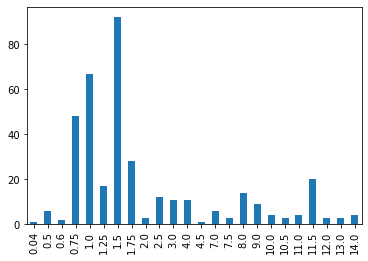

In [105]:
gdf_light["sy_mean"].value_counts().sort_index().plot(kind='bar')
plt.show()

In [106]:
gdf_light.to_file(opPath)